<a href="https://colab.research.google.com/github/pyijiezhang/cold-posteriors-and-pacbayes/blob/main/2023_Tempered_Posterior_Sigmoid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Code

In [ ]:
import numpy as np
from scipy.special import logsumexp, expit
import matplotlib.pyplot as plt


In [ ]:
thetas = np.linspace(-10, 10, num=1000)


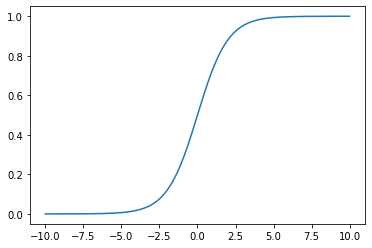

In [ ]:
plt.plot(thetas,1/(1+np.exp(-thetas)))

In [ ]:
1-expit(-1.0)

0.7310585786300049

In [ ]:
def loglikelihood_val(y, x):
  log_prob =  -np.log(1+np.exp(-thetas*y*x)) 
  return log_prob

def loglikelihood(hatheta, x):
  log_prob =  expit(x*hatheta)*loglikelihood_val(1., x) + expit(x*-hatheta)*loglikelihood_val(-1., x)
  return log_prob

def hatL(hatheta):
  return -0.5*loglikelihood(hatheta, 1.0) - 0.5*loglikelihood(hatheta, -1.0)

def L(thetastar):
  return -0.5*loglikelihood(thetastar, 1.0) - 0.5*loglikelihood(thetastar, -1.0)

def logprior(alpha):
  return -alpha*thetas**2
  #return -alpha*np.abs(thetas)

def logposterior(n, lamb, hattheta, alpha):
  return -n*lamb*hatL(hattheta) + logprior(alpha)

def normalize(vals):
  return np.exp(vals - logsumexp(vals))


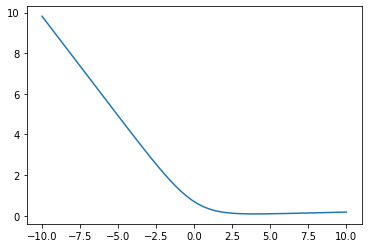

In [ ]:
plt.plot(thetas, L(4))

In [ ]:
print(thetas[np.argmin(hatL(4))])
print(np.min(hatL(4)))


3.9939939939939944
0.09009508694738413


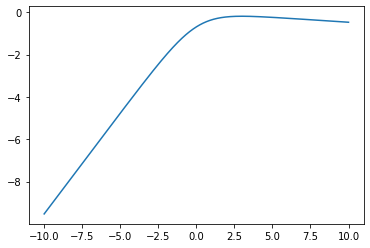

In [ ]:
plt.plot(thetas,loglikelihood(3, 1))

In [ ]:
def prior(alpha):
  return normalize(logprior(alpha))

def posterior(n, lamb, hattheta, alpha):
  return normalize(logposterior(n, lamb, hattheta, alpha))

def updatedposterior(n, lamb, hattheta, alpha, thetastar):
  
  total = 0
  vals = ((1,1),(-1,1),(1,-1),(-1,-1))
  for val in vals:
    y=val[0]
    x=val[1]
    nu_y_x = 0.5 * expit(y*x*thetastar)
    posterior_y_x = normalize(-n*lamb*hatL(hattheta) + loglikelihood_val(y,x) + logprior(alpha))
    total += nu_y_x*posterior_y_x
  
  return total

In [ ]:
def hatG(n, hattheta, posterior_vals):
  return n*np.dot(hatL(hattheta),posterior_vals)

def B(n, thetastar, posterior_vals):
  total = 0
  vals = ((1,1),(-1,1),(1,-1),(-1,-1))
  for val in vals:
    y=val[0]
    x=val[1]
    nu_y_x = 0.5 * expit(y*x*thetastar)
    #E_\rho[p(y=1|x=1,\theta)]
    prob = np.dot(posterior_vals,np.exp(loglikelihood_val(y,x)))
    total-=nu_y_x*np.log(prob)
 
  return total

# \E_nu[\E_\rho[p(y|x,\theta)]]
def expectedProb(thetastar, posterior_vals):
  # expected_prob = \E_nu[p(y|x,\theta)]
  expected_prob = 0
  vals = ((1,1),(-1,1),(1,-1),(-1,-1))
  for val in vals:
    y=val[0]
    x=val[1]
    nu_y_x = 0.5 * expit(y*x*thetastar)
    prob = np.exp(loglikelihood_val(y,x))
    expected_prob += nu_y_x*prob

  #\E_nu[\E_\rho[p(y|x,\theta)]]
  return np.dot(expected_prob,posterior_vals)


# Section 1: Low Aleatoric Uncertatiny Data - High Aleatoric Uncertainty Model

In [ ]:
n=5
lamb=1
hattheta=4
alpha=1
thetastar=3
lamb_vals = np.linspace(1, 10, num=1000)
print(expit(thetastar))
print(expit(hattheta))

0.9525741268224334
0.9820137900379085


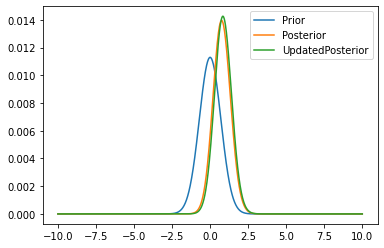

In [ ]:
plt.plot(thetas, prior(alpha), label='Prior')
plt.plot(thetas, posterior(n, lamb, hattheta, alpha),  label='Posterior')
plt.plot(thetas, updatedposterior(n, lamb, hattheta, alpha, thetastar),  label='UpdatedPosterior')
plt.legend()

In [ ]:
expectedProb(thetastar, posterior(n, lamb, hattheta, alpha))

0.6561743270651683

In [ ]:
print(thetas[np.argmax(posterior(n, lamb, hattheta, alpha))])
print(thetas[np.argmax(updatedposterior(n, lamb, hattheta, alpha,thetastar))])

0.7507507507507505
0.8308308308308305


In [ ]:
hatG_p_vals = np.array([hatG(n, hattheta, posterior(n, lamb_val, hattheta, alpha)) for lamb_val in lamb_vals])
hatG_updatedp_vals = np.array([hatG(n, hattheta, updatedposterior(n, lamb_val, hattheta, alpha, thetastar)) for lamb_val in lamb_vals])
B_vals = np.array([B(n, thetastar, posterior(n, lamb_val, hattheta, alpha)) for lamb_val in lamb_vals])

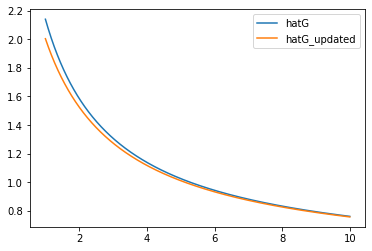

In [ ]:
plt.plot(lamb_vals, hatG_p_vals, label='hatG')
plt.plot(lamb_vals, hatG_updatedp_vals, label='hatG_updated')
plt.legend()

In [ ]:
hatG_updatedp_vals[0] - hatG_p_vals[0]

-0.1362583041972787

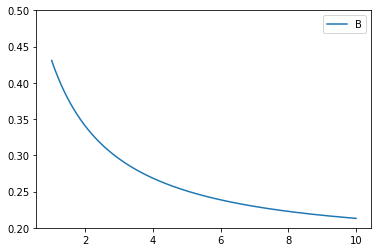

In [ ]:
plt.plot(lamb_vals, B_vals, label='B')
plt.ylim((0.2,0.5))
plt.legend()

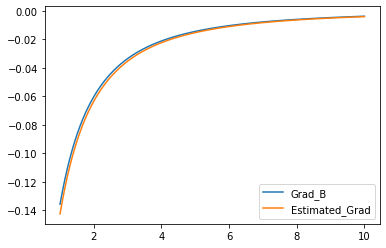

In [ ]:
#Double checking gradients
plt.plot(lamb_vals[1:], [(B_vals[i]-B_vals[i-1])/(lamb_vals[i]-lamb_vals[i-1]) for i in range(1,lamb_vals.shape[0])], label='Grad_B')
plt.plot(lamb_vals[1:], [hatG_updatedp_vals[i]-hatG_p_vals[i-1] for i in range(1,lamb_vals.shape[0])], label='Estimated_Grad')
#plt.ylim((0.3,0.4))
plt.legend()

# Label Noise


In [ ]:
n=5
lamb=1
hattheta=1.5
alpha=1
thetastar=1
lamb_vals = np.linspace(1, 10, num=1000)
print(expit(hattheta))
print(expit(thetastar))

0.8175744761936437
0.7310585786300049


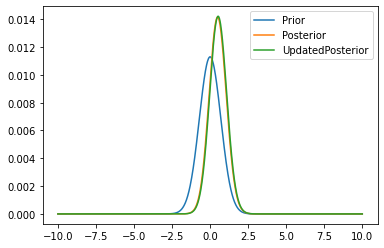

In [ ]:
plt.plot(thetas, prior(alpha), label='Prior')
plt.plot(thetas, posterior(n, lamb, hattheta, alpha),  label='Posterior')
plt.plot(thetas, updatedposterior(n, lamb, hattheta, alpha, thetastar),  label='UpdatedPosterior')
plt.legend()

In [ ]:
expectedProb(thetastar, posterior(n, lamb, hattheta, alpha))

0.5533374390078496

In [ ]:
print(thetas[np.argmax(posterior(n, lamb, hattheta, alpha))])
print(thetas[np.argmax(updatedposterior(n, lamb, hattheta, alpha,thetastar))])

0.4904904904904903
0.5305305305305303


In [ ]:
hatG_p_vals = np.array([hatG(n, hattheta, posterior(n, lamb_val, hattheta, alpha)) for lamb_val in lamb_vals])
hatG_updatedp_vals = np.array([hatG(n, hattheta, updatedposterior(n, lamb_val, hattheta, alpha, thetastar)) for lamb_val in lamb_vals])
B_vals = np.array([B(n, thetastar, posterior(n, lamb_val, hattheta, alpha)) for lamb_val in lamb_vals])

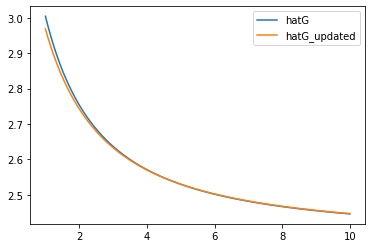

In [ ]:
plt.plot(lamb_vals, hatG_p_vals, label='hatG')
plt.plot(lamb_vals, hatG_updatedp_vals, label='hatG_updated')
plt.legend()

In [ ]:
hatG_updatedp_vals[0] - hatG_p_vals[0]

-0.03588559854544604

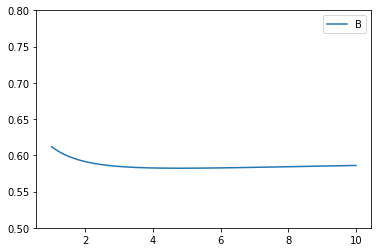

In [ ]:
plt.plot(lamb_vals, B_vals, label='B')
plt.ylim((0.5,0.8))
plt.legend()

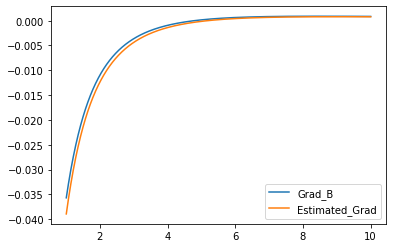

In [ ]:
#Double checking gradients
plt.plot(lamb_vals[1:], [(B_vals[i]-B_vals[i-1])/(lamb_vals[i]-lamb_vals[i-1]) for i in range(1,lamb_vals.shape[0])], label='Grad_B')
plt.plot(lamb_vals[1:], [hatG_updatedp_vals[i]-hatG_p_vals[i-1] for i in range(1,lamb_vals.shape[0])], label='Estimated_Grad')
#plt.ylim((0.3,0.4))
plt.legend()

# Data Replication


In [ ]:
n=1
lamb=1
hattheta=4
alpha=1
thetastar=3
lamb_vals = np.linspace(1, 10, num=1000)
print(expit(thetastar))
print(expit(hattheta))

0.9525741268224334
0.9820137900379085


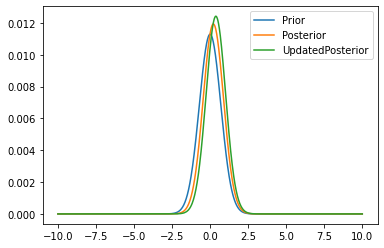

In [ ]:
plt.plot(thetas, prior(alpha), label='Prior')
plt.plot(thetas, posterior(n, lamb, hattheta, alpha),  label='Posterior')
plt.plot(thetas, updatedposterior(n, lamb, hattheta, alpha, thetastar),  label='UpdatedPosterior')
plt.legend()

In [ ]:
expectedProb(thetastar, posterior(n, lamb, hattheta, alpha))

0.544295858437239

In [ ]:
print(thetas[np.argmax(posterior(n, lamb, hattheta, alpha))])
print(thetas[np.argmax(updatedposterior(n, lamb, hattheta, alpha,thetastar))])

0.21021021021021014
0.37037037037037024


In [ ]:
hatG_p_vals = np.array([hatG(n, hattheta, posterior(n, lamb_val, hattheta, alpha)) for lamb_val in lamb_vals])
hatG_updatedp_vals = np.array([hatG(n, hattheta, updatedposterior(n, lamb_val, hattheta, alpha, thetastar)) for lamb_val in lamb_vals])
B_vals = np.array([B(n, thetastar, posterior(n, lamb_val, hattheta, alpha)) for lamb_val in lamb_vals])

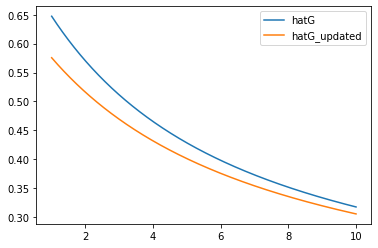

In [ ]:
plt.plot(lamb_vals, hatG_p_vals, label='hatG')
plt.plot(lamb_vals, hatG_updatedp_vals, label='hatG_updated')
plt.legend()

In [ ]:
hatG_updatedp_vals[0] - hatG_p_vals[0]

-0.07188366543690483

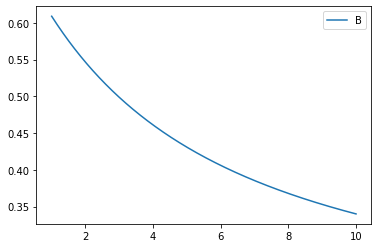

In [ ]:
plt.plot(lamb_vals, B_vals, label='B')
#plt.ylim((0.2,0.5))
plt.legend()

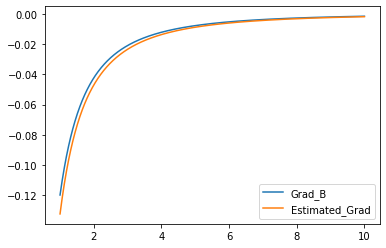

In [ ]:
#Double checking gradients
plt.plot(lamb_vals[1:], [(B_vals[i]-B_vals[i-1])/(lamb_vals[i]-lamb_vals[i-1]) for i in range(1,lamb_vals.shape[0])], label='Grad_B')
plt.plot(lamb_vals[1:], [hatG_updatedp_vals[i]-hatG_p_vals[i-1] for i in range(1,lamb_vals.shape[0])], label='Estimated_Grad')
#plt.ylim((0.3,0.4))
plt.legend()

# Smoothed Softmax

In [ ]:
T=5
def loglikelihood_val(y, x):
  log_prob =  -np.log(1+np.exp(-T*thetas*y*x)) 
  return log_prob


In [ ]:
n=5
lamb=1
hattheta=4
alpha=0.5
thetastar=3
lamb_vals = np.linspace(1, 10, num=1000)
print(expit(thetastar))
print(expit(hattheta))

0.9525741268224334
0.9820137900379085


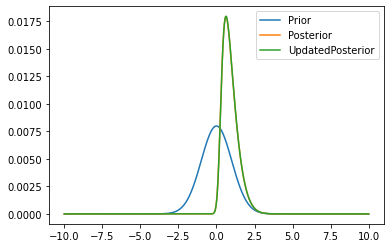

In [ ]:
plt.plot(thetas, prior(alpha), label='Prior')
plt.plot(thetas, posterior(n, lamb, hattheta, alpha),  label='Posterior')
plt.plot(thetas, updatedposterior(n, lamb, hattheta, alpha, thetastar),  label='UpdatedPosterior')
plt.legend()

In [ ]:
expectedProb(thetastar, posterior(n, lamb, hattheta, alpha))

0.9036218772682503

In [ ]:
print(thetas[np.argmax(posterior(n, lamb, hattheta, alpha))])
print(thetas[np.argmax(updatedposterior(n, lamb, hattheta, alpha,thetastar))])

0.6306306306306304
0.6306306306306304


In [ ]:
hatG_p_vals = np.array([hatG(n, hattheta, posterior(n, lamb_val, hattheta, alpha)) for lamb_val in lamb_vals])
hatG_updatedp_vals = np.array([hatG(n, hattheta, updatedposterior(n, lamb_val, hattheta, alpha, thetastar)) for lamb_val in lamb_vals])
B_vals = np.array([B(n, thetastar, posterior(n, lamb_val, hattheta, alpha)) for lamb_val in lamb_vals])

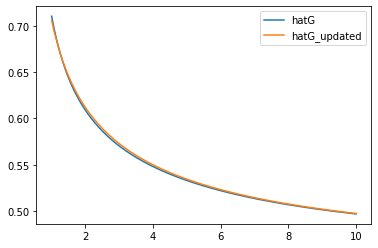

In [ ]:
plt.plot(lamb_vals, hatG_p_vals, label='hatG')
plt.plot(lamb_vals, hatG_updatedp_vals, label='hatG_updated')
plt.legend()

In [ ]:
hatG_updatedp_vals[0] - hatG_p_vals[0]

-0.004409614661499139

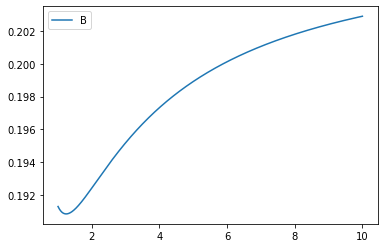

In [ ]:
plt.plot(lamb_vals, B_vals, label='B')
#plt.ylim((0.0,0.6))
plt.legend()

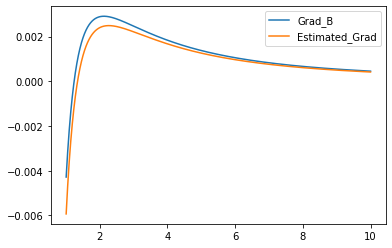

In [ ]:
#Double checking gradients
plt.plot(lamb_vals[1:], [(B_vals[i]-B_vals[i-1])/(lamb_vals[i]-lamb_vals[i-1]) for i in range(1,lamb_vals.shape[0])], label='Grad_B')
plt.plot(lamb_vals[1:], [hatG_updatedp_vals[i]-hatG_p_vals[i-1] for i in range(1,lamb_vals.shape[0])], label='Estimated_Grad')
#plt.ylim((0.3,0.4))
plt.legend()

# CPE is not a sign of model misspecification

In [ ]:
T=5
def loglikelihood_val(y, x):
  log_prob =  -np.log(1+np.exp(-T*thetas*y*x)) 
  return log_prob


In [ ]:
n=5
lamb=1
hattheta=5
alpha=1
thetastar=1
lamb_vals = np.linspace(1, 10, num=1000)
print(expit(hattheta))
print(expit(thetastar))

0.9933071490757153
0.7310585786300049


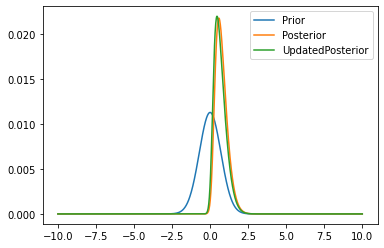

In [ ]:
plt.plot(thetas, prior(alpha), label='Prior')
plt.plot(thetas, posterior(n, lamb, hattheta, alpha),  label='Posterior')
plt.plot(thetas, updatedposterior(n, lamb, hattheta, alpha, thetastar),  label='UpdatedPosterior')
plt.legend()

In [ ]:
expectedProb(thetastar, posterior(n, lamb, hattheta, alpha))

0.7000527477914544

In [ ]:
print(thetas[np.argmax(posterior(n, lamb, hattheta, alpha))])
print(thetas[np.argmax(updatedposterior(n, lamb, hattheta, alpha,thetastar))])

0.5705705705705704
0.4504504504504503


In [ ]:
hatG_p_vals = np.array([hatG(n, hattheta, posterior(n, lamb_val, hattheta, alpha)) for lamb_val in lamb_vals])
hatG_updatedp_vals = np.array([hatG(n, hattheta, updatedposterior(n, lamb_val, hattheta, alpha, thetastar)) for lamb_val in lamb_vals])
B_vals = np.array([B(n, thetastar, posterior(n, lamb_val, hattheta, alpha)) for lamb_val in lamb_vals])

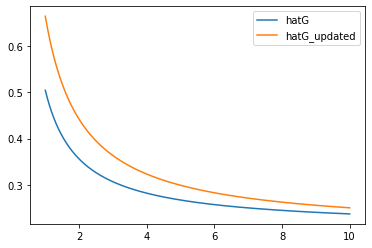

In [ ]:
plt.plot(lamb_vals, hatG_p_vals, label='hatG')
plt.plot(lamb_vals, hatG_updatedp_vals, label='hatG_updated')
plt.legend()

In [ ]:
hatG_updatedp_vals[0] - hatG_p_vals[0]

0.16001738147558342

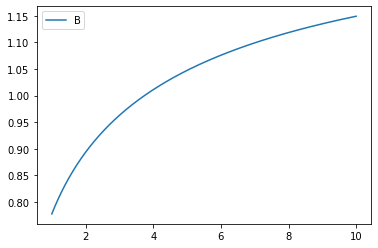

In [ ]:
plt.plot(lamb_vals, B_vals, label='B')
#plt.ylim((0.5,0.8))
plt.legend()

# The Noise Dirichlet Model

In [ ]:
from scipy.stats import beta

alpha_epsilon=0.1
def loglikelihood_val(y, x):
  #return -np.log(1+np.exp(-thetas*y*x))
  prob =  np.exp(-np.log(1+np.exp(-thetas*y*x)))
  logpdf = beta.logpdf(prob, 1+alpha_epsilon, alpha_epsilon)
  return logpdf

def loglikelihood(hatheta, x):
  log_prob =  expit(x*hatheta)*loglikelihood_val(1., x) + expit(x*-hatheta)*loglikelihood_val(-1., x)
  return log_prob


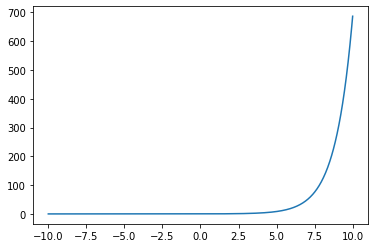

In [ ]:
plt.plot(thetas,np.exp(loglikelihood(hattheta, 1)))

In [ ]:
n=5
lamb=1
hattheta=4
alpha=0.5
thetastar=3
lamb_vals = np.linspace(1, 10, num=1000)
print(expit(thetastar))
print(expit(hattheta))

0.9525741268224334
0.9820137900379085


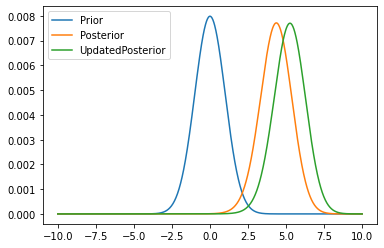

In [ ]:
plt.plot(thetas, prior(alpha), label='Prior')
plt.plot(thetas, posterior(n, lamb, hattheta, alpha),  label='Posterior')
plt.plot(thetas, updatedposterior(n, lamb, hattheta, alpha, thetastar),  label='UpdatedPosterior')
plt.legend()

In [ ]:
expectedProb(thetastar, posterior(n, lamb, hattheta, alpha))

7.344341713061897

In [ ]:
print(thetas[np.argmax(posterior(n, lamb, hattheta, alpha))])
print(thetas[np.argmax(updatedposterior(n, lamb, hattheta, alpha,thetastar))])

4.354354354354355
5.255255255255255


In [ ]:
hatG_p_vals = np.array([hatG(n, hattheta, posterior(n, lamb_val, hattheta, alpha)) for lamb_val in lamb_vals])
hatG_updatedp_vals = np.array([hatG(n, hattheta, updatedposterior(n, lamb_val, hattheta, alpha, thetastar)) for lamb_val in lamb_vals])
B_vals = np.array([B(n, thetastar, posterior(n, lamb_val, hattheta, alpha)) for lamb_val in lamb_vals])

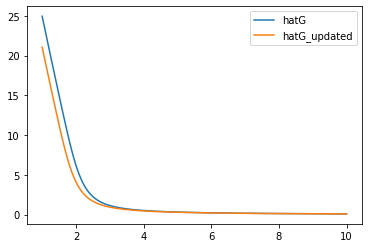

In [ ]:
plt.plot(lamb_vals, hatG_p_vals, label='hatG')
plt.plot(lamb_vals, hatG_updatedp_vals, label='hatG_updated')
plt.legend()

In [ ]:
hatG_updatedp_vals[0] - hatG_p_vals[0]

-3.8960964141525096

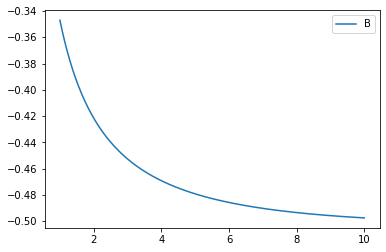

In [ ]:
plt.plot(lamb_vals, B_vals, label='B')
#plt.ylim((0.0,0.6))
plt.legend()

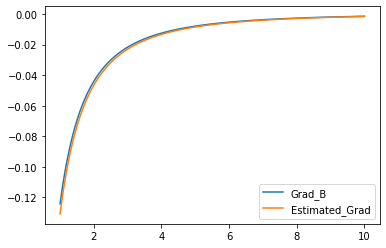

In [ ]:
#Double checking gradients
plt.plot(lamb_vals[1:], [(B_vals[i]-B_vals[i-1])/(lamb_vals[i]-lamb_vals[i-1]) for i in range(1,lamb_vals.shape[0])], label='Grad_B')
plt.plot(lamb_vals[1:], [hatG_updatedp_vals[i]-hatG_p_vals[i-1] for i in range(1,lamb_vals.shape[0])], label='Estimated_Grad')
#plt.ylim((0.3,0.4))
plt.legend()

# The Role of the Prior

In [ ]:
n=5
lamb=1
hattheta=4
alpha=-1
thetastar=3
lamb_vals = np.linspace(1, 10, num=1000)
print(expit(thetastar))
print(expit(hattheta))

0.9525741268224334
0.9820137900379085


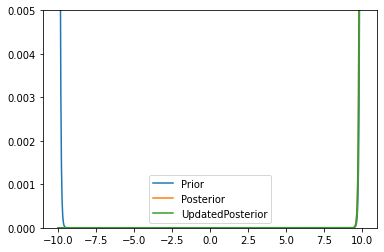

In [ ]:
plt.plot(thetas, prior(alpha), label='Prior')
plt.plot(thetas, posterior(n, lamb, hattheta, alpha),  label='Posterior')
plt.plot(thetas, updatedposterior(n, lamb, hattheta, alpha, thetastar),  label='UpdatedPosterior')
plt.ylim((0,0.005))
plt.legend()

In [ ]:
expectedProb(thetastar, posterior(n, lamb, hattheta, alpha))

0.9525312435343831

In [ ]:
hatG_p_vals = [hatG(n, hattheta, posterior(n, lamb_val, hattheta, alpha)) for lamb_val in lamb_vals]
hatG_updatedp_vals = [hatG(n, hattheta, updatedposterior(n, lamb_val, hattheta, alpha, thetastar)) for lamb_val in lamb_vals]
B_vals = [B(n, thetastar, posterior(n, lamb_val, hattheta, alpha)) for lamb_val in lamb_vals]

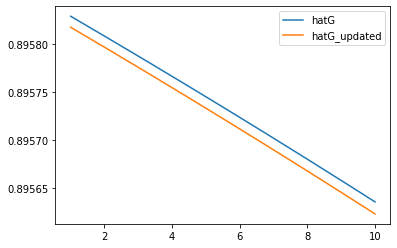

In [ ]:
plt.plot(lamb_vals, hatG_p_vals, label='hatG')
plt.plot(lamb_vals, hatG_updatedp_vals, label='hatG_updated')
plt.legend()

In [ ]:
hatG_updatedp_vals[0] - hatG_p_vals[0]

-1.1496148899836633e-05

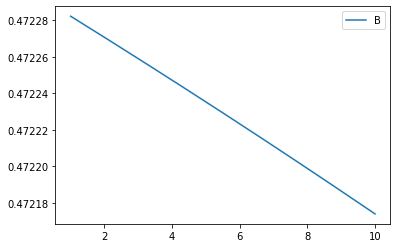

In [ ]:
plt.plot(lamb_vals, B_vals, label='B')
#plt.ylim((0.15,0.35))
plt.legend()

# The Role of the Prior II

In [ ]:
lamb=1.0
alpha_vals = np.linspace(0.01, 10, num=100)
hatG_p_vals = [hatG(n, hattheta, posterior(n, lamb, hattheta, alpha_val)) for alpha_val in alpha_vals]
hatG_updatedp_vals = [hatG(n, hattheta, updatedposterior(n, lamb, hattheta, alpha_val, thetastar)) for alpha_val in alpha_vals]
B_vals = [B(n, thetastar, posterior(n, lamb, hattheta, alpha_val)) for alpha_val in alpha_vals]

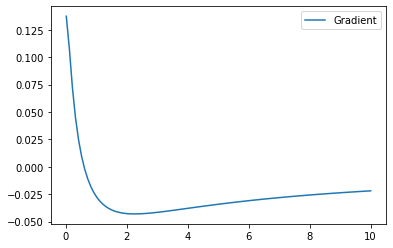

In [ ]:
plt.plot(alpha_vals, np.array(hatG_updatedp_vals)-np.array(hatG_p_vals), label='Gradient')
plt.legend()

# 1. Low Aleatoric Uncertatiny Data - High Aleatoric Uncertainty Model

In [ ]:
n=5
lamb=1
hattheta=4
alpha=1
thetastar=3
lamb_vals = np.linspace(1, 100, num=1000)
print(expit(thetastar))
print(expit(hattheta))

0.9525741268224334
0.9820137900379085


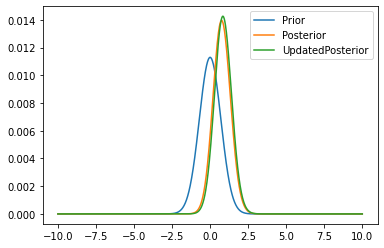

In [ ]:
lamb=1
plt.plot(thetas, prior(alpha), label='Prior')
plt.plot(thetas, posterior(n, lamb, hattheta, alpha),  label='Posterior')
plt.plot(thetas, updatedposterior(n, lamb, hattheta, alpha, thetastar),  label='UpdatedPosterior')
plt.legend()

In [ ]:
expectedProb(thetastar, posterior(n, lamb, hattheta, alpha))

0.6561743270651683

In [ ]:
print(thetas[np.argmax(posterior(n, lamb, hattheta, alpha))])
print(thetas[np.argmax(updatedposterior(n, lamb, hattheta, alpha,thetastar))])

0.7507507507507505
0.8308308308308305


In [ ]:
hatG_p_vals = np.array([hatG(n, hattheta, posterior(n, lamb_val, hattheta, alpha)) for lamb_val in lamb_vals])
hatG_updatedp_vals = np.array([hatG(n, hattheta, updatedposterior(n, lamb_val, hattheta, alpha, thetastar)) for lamb_val in lamb_vals])
B_vals = np.array([B(n, thetastar, posterior(n, lamb_val, hattheta, alpha)) for lamb_val in lamb_vals])

In [ ]:
theta_mle = np.argmax(posterior(n, 1.0, hattheta, 0.0))
Lhat_min = n*hatL(hattheta)[theta_mle]
Lhat_min

0.45047543473692064

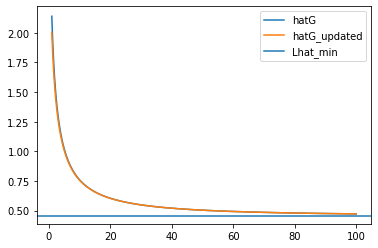

In [ ]:
plt.plot(lamb_vals, hatG_p_vals, label='hatG')
plt.plot(lamb_vals, hatG_updatedp_vals, label='hatG_updated')
plt.axhline(Lhat_min, label='Lhat_min')
plt.legend()

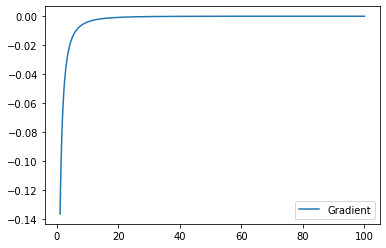

In [ ]:
gradient = hatG_updatedp_vals-hatG_p_vals
plt.plot(lamb_vals, gradient, label='Gradient')
plt.legend()


In [ ]:
hatG_updatedp_vals[0] - hatG_p_vals[0]

-0.1362583041972787

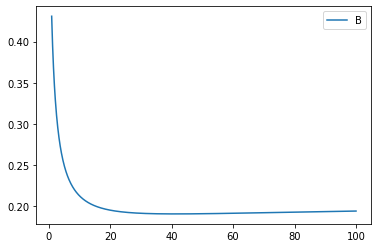

In [ ]:
plt.plot(lamb_vals, B_vals, label='B')
#plt.ylim((0.2,0.5))
plt.legend()

In [ ]:
def kl(log_qA, log_qB):
  return np.dot(np.exp(log_qA),log_qA-log_qB)

In [ ]:
KL_vals = np.array([kl(updatedposterior(n, lamb_val, hattheta, alpha, thetastar),posterior(n, lamb_val, hattheta, alpha)) for lamb_val in lamb_vals])

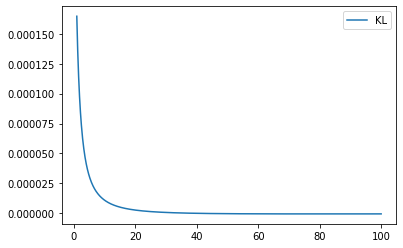

In [ ]:
plt.plot(lamb_vals,KL_vals, label='KL')
plt.legend()

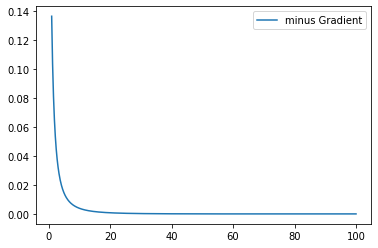

In [ ]:
plt.plot(lamb_vals,-gradient, label='minus Gradient')
plt.legend()